In [9]:
from thermalmodels_second import SecondOrderModel as second_temp_model
from second_thermalenvironments import DirectSetpointEnv as second_temp_env

In [10]:
from thermalmodels_second_price import SecondOrderModel as second_price_model
from second_thermalenvironments_price import DirectSetpointEnv as second_price_env

In [11]:
from thermalmodels_second_price_noise import SecondOrderModel as price_noise_model
from second_thermalenvironments_price_noise import DirectSetpointEnv as price_noise_env

In [12]:
from thermalmodels_second_noise import SecondOrderModel as temp_noise_model
from second_thermalenvironments_noise import DirectSetpointEnv as temp_noise_env

In [13]:
from thermalmodels_first import FirstOrderModel as first_temp_model
from first_thermalenvironments import DirectSetpointEnv as first_temp_env


In [14]:
from thermalmodels_first_price import FirstOrderModel as first_price_model
from first_thermalenvironments_price import DirectSetpointEnv as first_price_env


In [15]:
from stable_baselines import DQN, A2C,PPO2,ACER,TRPO,ACKTR
from stable_baselines.common.vec_env import DummyVecEnv
from itertools import cycle
import pandas as pd
import numpy as np

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [22]:
# Getting the rl_squared training procedure
from evaluate import evaluate
from meta_rl2 import rl_squared

In [23]:
# Reading in the prices from the combined_csv file
df = pd.read_csv('combined_csv.csv')
prices = df[["Spot Price ($/MWh)"]]      
prices = np.array(prices)

In [24]:
# Create the second order envs
#house dynamics = second order, objective = Only maintain a fixed temperature 
tcl1 = second_temp_model(pHouse=0)    # Calling the function firstorder model arg1,2- seconds to heat and seconds to cool, arg3-Goal, flex and noise
env1 = second_temp_env(tcl1,prices) 
env1 = DummyVecEnv([lambda: env1]) # Converting to dummy env for PPO2

#house dynamics = second order, objective = Tradeoff price with comf
tcl2 = second_price_model(pHouse =1)
env2 = second_price_env(tcl2,prices)
env2 =DummyVecEnv([lambda: env2])
second_env = [env1,env2] # both the 2nd order env's

In [25]:
# Randomly developing first order envs, 3 for temp only and 3 for price+temp

temp_env = []
price_env = []
time_heat_all = []
time_cool_all = []

for i in range(3):
    
    time_heat = round(np.random.uniform(low=8,high=26))
            
    time_cool = time_heat*2 + round(np.random.uniform(low=-4,high=8))
            
    tcl = first_temp_model(time_heat*60,time_cool*60,21,1.5)
    env = first_temp_env(tcl,prices)
    env =DummyVecEnv([lambda: env])
    time_heat_all.append(time_heat)
    time_cool_all.append(time_cool)
    temp_env.append(env)

for i in range(3):
    time_heat = round(np.random.uniform(low=8,high=26))
            
    time_cool = time_heat*2 + round(np.random.uniform(low=-4,high=8))
            
    tcl = first_price_model(time_heat*60,time_cool*60,21,1.5)
    env = first_price_env(tcl,prices)
    env =DummyVecEnv([lambda: env])
    time_heat_all.append(time_heat)
    time_cool_all.append(time_cool)
    
    price_env.append(env)
    
first_env = temp_env+price_env # 6 of the first order env's

In [26]:
time_heat_all

[13, 21, 13, 24, 22, 19]

In [27]:
# Joining all houses to 1 array, first 2 are second order and the rest are 1st order
env = second_env + first_env
env

In [28]:
reward_2,dynamics,model_2 = rl_squared(500,env)






Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
Episode: 10
Episode: 11
Episode: 12
Episode: 13
Episode: 14
Episode: 15
Episode: 16
Episode: 17
Episode: 18
Episode: 19
Episode: 20
Episode: 21
Episode: 22
Episode: 23
Episode: 24
Episode: 25
Episode: 26
Episode: 27
Episode: 28
Episode: 29
Episode: 30
Episode: 31
Episode: 32
Episode: 33
Episode: 34
Episode: 35
Episode: 36
Episode: 37
Episode: 38
Episode: 39
Episode: 40
Episode: 41
Episode: 42
Episode: 43
Episode: 44
Episode: 45
Episode: 46
Episode: 47
Episode: 48
Episode: 49
Episode: 50
Episode: 51
Episode: 52
Episode: 53
Episode: 54
Episode: 55
Episode: 56
Episode: 57
Episode: 58
Episode: 59
Episode: 60
Episode: 61
Episode: 62
Episode: 63
Epi

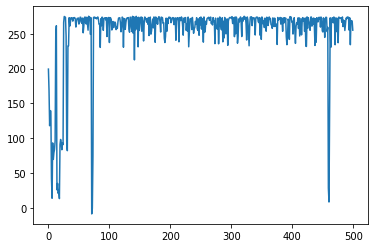

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

l = []
l.extend(range(0, 500))
plt.plot(l,reward_2)

Text(0, 0.5, 'Reward')

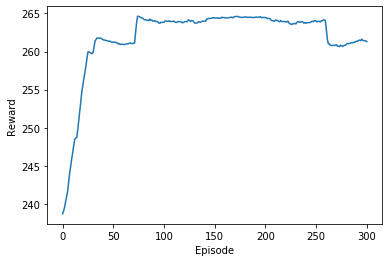

In [45]:
# Calculating a moving avg of the rewards
mylist = reward_2
N = 200
cumsum, moving_aves = [0], []


for i, x in enumerate(mylist, 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=N:
        moving_ave = (cumsum[i] - cumsum[i-N])/N
        #can do stuff with moving_ave here
        moving_aves.append(moving_ave)

l = []
l.extend(range(0, len(moving_aves)))
plt.plot(l,moving_aves)
plt.xlabel('Episode')
plt.ylabel('Reward')

In [46]:
moving_aves = np.array(moving_aves)
np.savetxt("rl2_task1_task2.csv", moving_aves, delimiter=",")

Text(0, 0.5, 'Action')

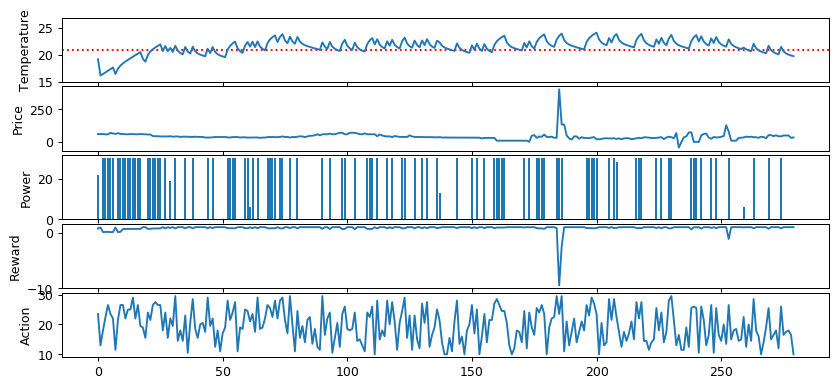

In [88]:
# Visualising the policy on 1 episode
seconds3 = []
price3 = []
reward3 = []
temp3 = []
setpoint3 = []
times = []
comf = []
obs = env[0].reset()
cost = []
dones = False
#while not dones:
for i in range(288):
    
    action, _states = model_specific.predict(obs)
    obs, rewards, dones, info = env[1].step(action)
    
    seconds3.append(info[0]['SecondsON'])
    setpoint3.append((info[0]['Action']/2) + 10)
    reward3.append(rewards)
    times.append(i)
    temp3.append(obs[0][0])
    comf.append(info[0]['Comfort'])
    cost.append(info[0]['Cost'])
    price3.append(info[0]['Price'])
   # print(obs[0],rewards,info)

   # env.render(mode='human')
### Plot the resulting temperature trajectory.
f, (ax1, ax2, ax3,ax4,ax5) = plt.subplots(5, 1, sharex=True, figsize=(11,5), dpi=90)
plt.subplots_adjust(hspace=0.075) # Reduce space between plots
#ax1.axvspan(60, 66, facecolor='0.95') # Shade the demand-response times with grey background
#ax1.axvspan(200, 206, facecolor='0.95')

#ax2.axvspan(60, 66, facecolor='0.85') # Shade the demand-response times with grey background
#ax2.axvspan(200, 206, facecolor='0.85')

ax1.axhline(y=21, linestyle=':', color='red') # Plot the goal temperature
ax1.plot(times[:280], temp3[:280]) # Plot the observed temperatures
ax1.set_ylabel('Temperature')
ax1.set_ylim(15,27)
ax2.plot(times[:280], price3[:280]) # Plot the activations on a separate axis.
ax2.set_xlabel('Timestep')
ax2.set_ylabel('Price');
ax3.bar(times[:280],seconds3[:280])
ax3.set_ylabel('Power');

ax4.plot(times[:280],reward3[:280])
ax4.set_ylabel('Reward')

ax5.plot(times[:280],setpoint3[:280])
ax5.set_ylabel('Action')  
    
    

In [44]:
# Testing on one of the price tasks from the training task dist itself
env_test = env[0]


In [ ]:
plt.rcParams['figure.figsize'] = [6, 2]
plt.rcParams['figure.dpi'] = 150


In [66]:
# Using house 3 (2nd order-temp only) for testing 
tcl3 = second_price_model(pHouse =2)
env3 = second_price_env(tcl3,prices)
env3 =DummyVecEnv([lambda: env3])

# # Using house 3 (2nd order-with price) for testing 
tcl4 = second_temp_model(pHouse =2)
env4 = second_temp_env(tcl4,prices)
env4 =DummyVecEnv([lambda: env4])

In [67]:
mean_reward, std_reward,mean_cost,std_cost,mean_comfort,stdcomfort=evaluate(model_2, env3, n_eval_episodes=50,baseline = False)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:260.15 +/- 11.50


In [68]:
mean_reward, std_reward,mean_cost,std_cost,mean_comfort,stdcomfort=evaluate(model_2, env4, n_eval_episodes=50,baseline = False)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:267.57 +/- 1.76


In [76]:
# Set up 2 first orders
while time_heat in time_heat_all:
    time_heat = round(np.random.uniform(low=8,high=26))
            
time_cool = time_heat*2 + round(np.random.uniform(low=-4,high=8))
            
tcl5 = first_price_model(time_heat*60,time_cool*60,21,1.5)
env5 = first_price_env(tcl5,prices)
env5 =DummyVecEnv([lambda: env5])

# First order temp only
while time_heat in time_heat_all:
    time_heat = round(np.random.uniform(low=8,high=26))
            
time_cool = time_heat*2 + round(np.random.uniform(low=-4,high=8))
            
tcl6 = first_temp_model(time_heat*60,time_cool*60,21,1.5)
env6 = first_temp_env(tcl6,prices)
env6 =DummyVecEnv([lambda: env6])


In [77]:
mean_reward, std_reward,mean_cost,std_cost,mean_comfort,stdcomfort=evaluate(model_2, env5, n_eval_episodes=50,baseline = False)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:267.79 +/- 8.57


In [78]:
mean_reward, std_reward,mean_cost,std_cost,mean_comfort,stdcomfort=evaluate(model_2, env6, n_eval_episodes=50,baseline = False)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:273.58 +/- 0.76


In [93]:
# Calculating for task specific policy-Price(2nd)
model_specific = ACKTR("MlpPolicy", env3, gamma=0.95, verbose=0,seed = 9099,tensorboard_log="/floyd/home/sec_order") 
model_specific.learn(total_timesteps=90000)
mean_reward, std_reward,mean_cost,std_cost,mean_comfort,stdcomfort=evaluate(model_specific, env3, n_eval_episodes=50,baseline = True)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:257.99 +/- 11.54


In [95]:
# Calculating for task specific policy-Temp(2nd)
model_specific = ACKTR("MlpPolicy", env4, gamma=0.95, verbose=0,seed = 9099) 
model_specific.learn(total_timesteps=90000)
mean_reward, std_reward,mean_cost,std_cost,mean_comfort,stdcomfort=evaluate(model_specific, env4, n_eval_episodes=50,baseline = True)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:270.39 +/- 2.30


In [96]:
# Calculating for task specific policy-1st(price)
model_specific = ACKTR("MlpPolicy", env5, gamma=0.95, verbose=0,seed = 9099) 
model_specific.learn(total_timesteps=90000) 
mean_reward, std_reward,mean_cost,std_cost,mean_comfort,stdcomfort=evaluate(model_specific, env5, n_eval_episodes=50,baseline = True)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:267.37 +/- 8.93


In [97]:
# Calculating for task specific policy -temp(1st)
model_specific = ACKTR("MlpPolicy", env6, gamma=0.95, verbose=0,seed = 9099) 
model_specific.learn(total_timesteps=90000)
mean_reward, std_reward,mean_cost,std_cost,mean_comfort,stdcomfort=evaluate(model_specific, env6, n_eval_episodes=50,baseline = True)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:273.73 +/- 0.89


In [44]:
env = env3
env = DummyVecEnv([lambda: env])

In [68]:
seconds3 = []
price3 = []
reward3 = []
temp3 = []
setpoint3 = []
times = []
comf = []
obs = env.reset()
cost = []
dones = False
#while not dones:
for i in range(300):
    
    action, _states = specific_m.predict(obs)
    obs, rewards, dones, info = env.step(action)
    
    seconds3.append(info[0]['SecondsON'])
    setpoint3.append((info[0]['Action']/2) + 10)
    reward3.append(rewards)
    times.append(i)
    temp3.append(obs[0][0])
    comf.append(info[0]['Comfort'])
    cost.append(info[0]['Cost'])
    price3.append(info[0]['Price'])
   # print(obs[0],rewards,info)

   # env.render(mode='human')

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0, 0.5, 'Action')

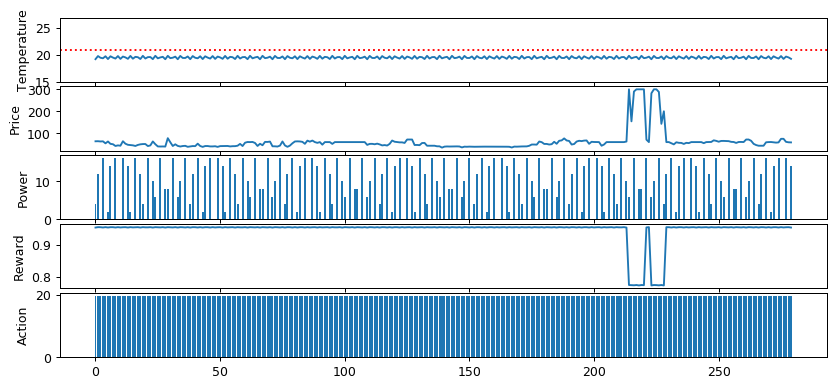

In [55]:
### Plot the resulting temperature trajectory.
f, (ax1, ax2, ax3,ax4,ax5) = plt.subplots(5, 1, sharex=True, figsize=(11,5), dpi=90)
plt.subplots_adjust(hspace=0.075) # Reduce space between plots
#ax1.axvspan(60, 66, facecolor='0.95') # Shade the demand-response times with grey background
#ax1.axvspan(200, 206, facecolor='0.95')

#ax2.axvspan(60, 66, facecolor='0.85') # Shade the demand-response times with grey background
#ax2.axvspan(200, 206, facecolor='0.85')

ax1.axhline(y=21, linestyle=':', color='red') # Plot the goal temperature
ax1.plot(times[:280], temp3[:280]) # Plot the observed temperatures
ax1.set_ylabel('Temperature')
ax1.set_ylim(15,27)
ax2.plot(times[:280], price3[:280]) # Plot the activations on a separate axis.
ax2.set_xlabel('Timestep')
ax2.set_ylabel('Price');
ax3.bar(times[:280],seconds3[:280])
ax3.set_ylabel('Power');

ax4.plot(times[:280],reward3[:280])
ax4.set_ylabel('Reward')

ax5.bar(times[:280],setpoint3[:280])
ax5.set_ylabel('Action')

In [53]:
np.mean(action)

19.0

In [15]:
#Temp only
np.mean(reward3)


0.94458926

In [42]:
#Also price
np.mean(reward3)

0.94497305

In [43]:
np.mean(cost)

0.008161307373148149

In [28]:
min(cost),max(cost)

(0.0, 0.41922916666666665)